In [4]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

In [5]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")

In [6]:
df = pd.read_pickle(os.getcwd()+r"\Data Files\final_grids_combined.pkl")

In [7]:
df=df[df["NTC_FLAG"] == 'Others']

In [8]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,GRID_ID,RISK_SCORE
0,299690604,2020-03-18,19.265680,72.868973,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_00905_02662,0.051794
1,299690609,2020-03-18,19.004342,73.114270,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_00953_02602,0.007845
2,299690618,2020-03-18,26.139898,78.159472,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_02018_04121,0.034560
3,299690627,2020-03-18,26.933770,75.753160,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01551_04304,0.018181
4,299690631,2020-03-18,26.199419,78.162542,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_02019_04134,0.010261


In [9]:
df["RISK_SCORE"].isna().value_counts()

False    3362588
True     2540030
Name: RISK_SCORE, dtype: int64

In [10]:
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")
df_summ = df[["MONTH_STR","RISK_FSTQPD30"]].groupby("MONTH_STR").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

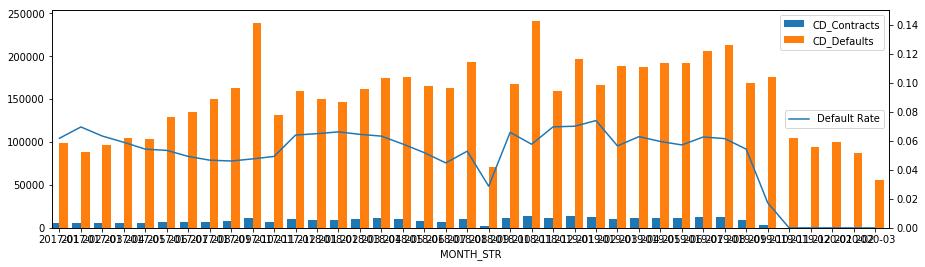

In [11]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


# Generate grid based scores for selected variables

In [20]:
hyper_df= pd.read_csv(os.getcwd()+r"\Data Files\Hyperparameters\Hyperparameters_exi.csv")

In [21]:
hyper_df.head()

,SCORE_NAME,TARGET,K,OBSERVATION_WINDOW,PERFORMANCE_WINDOW,DOWNSAMPLE_SIZE,FILLNA
0,RISK_FPD10_SCORE,RISK_FPD10,161,365,40,60000,0.509335
1,RISK_FPD30_SCORE,RISK_FPD30,66,365,60,20000,0.488066
2,RISK_FSPD30_SCORE,RISK_FSPD30,136,365,90,40000,0.497563
3,RISK_FSTPD30_SCORE,RISK_FSTPD30,166,365,120,70000,0.505412
4,RISK_FSTQPD30_SCORE,RISK_FSTQPD30,266,365,150,100000,0.513970


In [22]:
selected_list =['NO_PAYMENT_CURRENT_PAYMENT_1', 'DEFAULT_FLAG_CHANGE_1', 'RISK_FSTQPD30_SCORE', 'RISK_FSPD30_MM_SCORE']

In [23]:
# hyper_df= pd.read_csv(os.getcwd()+r"\Data Files\Hyperparameters.csv")
# df = pd.read_csv(os.getcwd()+r"\Data Files\final_grids.csv")
# df["TIME_DECISION_DATE"]=pd.to_datetime(df["TIME_DECISION_DATE"],format = '%d-%m-%y')

In [24]:
import datetime
from sklearn.neighbors import KNeighborsClassifier

df_final_test = pd.DataFrame()

for x in np.arange(1,9,1):
    date_test_start = datetime.datetime(2019, x, 1)
    date_test_end = (date_test_start +  datetime.timedelta(days=31)).replace(day=1)
    df_test = df[(df["TIME_DECISION_DATE"]>=date_test_start) & 
                      (df["TIME_DECISION_DATE"]<date_test_end)]

    for y in hyper_df.index:
#         if hyper_df.loc[y,'SCORE_NAME'] in selected_list:
        if True:
            score_name = hyper_df.loc[y,'SCORE_NAME']
            target = hyper_df.loc[y,'TARGET']
            K = hyper_df.loc[y,'K']
            observation_window = hyper_df.loc[y,'OBSERVATION_WINDOW']
            performance_window = hyper_df.loc[y,'PERFORMANCE_WINDOW']
            downsample_size = hyper_df.loc[y,'DOWNSAMPLE_SIZE']
            fillna = hyper_df.loc[y,'FILLNA']

            date_train_start = (date_test_start-datetime.timedelta(days=int(performance_window))-datetime.timedelta(days=int(observation_window))) 
            date_train_end = (date_test_start-datetime.timedelta(days=int(performance_window)))
            start_time = datetime.datetime.now()
            df_train = df[(df["TIME_DECISION_DATE"]>=date_train_start) & 
                      (df["TIME_DECISION_DATE"]<date_train_end)]

            df_class_0 = df_train[df_train[target] == 0]
            df_class_1 = df_train[df_train[target] == 1]
            df_class_0_under = df_class_0.sample(min(downsample_size,df_class_1.shape[0]))
            df_class_1_under = df_class_1.sample(min(downsample_size,df_class_1.shape[0]))
            df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

            X_train = df_train_under[["CUS_LAT","CUS_LONG"]]
            X_test = df_test[["CUS_LAT","CUS_LONG"]]
            y_train = df_train_under[target]
            y_test =  df_test[target]

            knn = KNeighborsClassifier(n_neighbors = K)
            bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

            ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
            ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]
            metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
            metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
            gini_train = 2 * metric_auc_train - 1
            gini_test = 2 * metric_auc_test - 1

            df_test[score_name] = ypred_test
            
            df_train_under ["G_"+score_name] = ypred_train
            grid_score = df_train_under[["GRID_ID","G_"+score_name]].groupby("GRID_ID").mean()["G_"+score_name].reset_index()
            grid_score.columns = ['GRID_ID',"G_"+score_name]
            
            df_test = pd.merge(df_test, grid_score, on = 'GRID_ID', how = 'left')
            df_test["G_"+score_name]=df_test["G_"+score_name].fillna(value = fillna)
            
            print("Training for predicting (month):",date_test_start.month, 
                  " SCORE:",score_name,
                  " target:",target,
                  " K:",K,
                  " observation_window:",observation_window,
                  " performance_window:",performance_window,
                  " downsample_size:",downsample_size,
                  " GINI TRAIN:",'{:,.2%}'.format(gini_train), "    GINI TEST:",'{:,.2%}'.format(gini_test),
                  " time taken: ",'{:,.2}'.format((datetime.datetime.now()-start_time).seconds/60))


    if df_final_test.shape == (0,0):
        df_final_test = df_test
    else:
        df_final_test = pd.concat([df_final_test,df_test],ignore_index=True)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 161  observation_window: 365  performance_window: 40  downsample_size: 60000  GINI TRAIN: 17.66%     GINI TEST: 10.07%  time taken:  0.27
Training for predicting (month): 1  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 66  observation_window: 365  performance_window: 60  downsample_size: 20000  GINI TRAIN: 24.69%     GINI TEST: 14.91%  time taken:  0.083
Training for predicting (month): 1  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 136  observation_window: 365  performance_window: 90  downsample_size: 40000  GINI TRAIN: 22.28%     GINI TEST: 14.28%  time taken:  0.2
Training for predicting (month): 1  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 166  observation_window: 365  performance_window: 120  downsample_size: 70000  GINI TRAIN: 19.90%     GINI TEST: 13.40%  time taken:  0.3
Training for predicting (month): 1  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 266  observation_

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 161  observation_window: 365  performance_window: 40  downsample_size: 60000  GINI TRAIN: 17.42%     GINI TEST: 10.60%  time taken:  0.27
Training for predicting (month): 2  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 66  observation_window: 365  performance_window: 60  downsample_size: 20000  GINI TRAIN: 24.34%     GINI TEST: 15.02%  time taken:  0.067
Training for predicting (month): 2  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 136  observation_window: 365  performance_window: 90  downsample_size: 40000  GINI TRAIN: 20.99%     GINI TEST: 14.80%  time taken:  0.2
Training for predicting (month): 2  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 166  observation_window: 365  performance_window: 120  downsample_size: 70000  GINI TRAIN: 20.03%     GINI TEST: 13.31%  time taken:  0.23
Training for predicting (month): 2  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 266  observation

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 161  observation_window: 365  performance_window: 40  downsample_size: 60000  GINI TRAIN: 17.26%     GINI TEST: 12.05%  time taken:  0.28
Training for predicting (month): 3  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 66  observation_window: 365  performance_window: 60  downsample_size: 20000  GINI TRAIN: 24.43%     GINI TEST: 15.33%  time taken:  0.083
Training for predicting (month): 3  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 136  observation_window: 365  performance_window: 90  downsample_size: 40000  GINI TRAIN: 21.02%     GINI TEST: 14.45%  time taken:  0.2
Training for predicting (month): 3  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 166  observation_window: 365  performance_window: 120  downsample_size: 70000  GINI TRAIN: 19.77%     GINI TEST: 12.52%  time taken:  0.32
Training for predicting (month): 3  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 266  observation

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 161  observation_window: 365  performance_window: 40  downsample_size: 60000  GINI TRAIN: 17.67%     GINI TEST: 12.40%  time taken:  0.23
Training for predicting (month): 4  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 66  observation_window: 365  performance_window: 60  downsample_size: 20000  GINI TRAIN: 24.65%     GINI TEST: 15.14%  time taken:  0.067
Training for predicting (month): 4  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 136  observation_window: 365  performance_window: 90  downsample_size: 40000  GINI TRAIN: 21.14%     GINI TEST: 14.42%  time taken:  0.2
Training for predicting (month): 4  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 166  observation_window: 365  performance_window: 120  downsample_size: 70000  GINI TRAIN: 19.58%     GINI TEST: 11.87%  time taken:  0.27
Training for predicting (month): 4  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 266  observation

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 161  observation_window: 365  performance_window: 40  downsample_size: 60000  GINI TRAIN: 17.42%     GINI TEST: 9.61%  time taken:  0.27
Training for predicting (month): 5  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 66  observation_window: 365  performance_window: 60  downsample_size: 20000  GINI TRAIN: 24.43%     GINI TEST: 13.83%  time taken:  0.067
Training for predicting (month): 5  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 136  observation_window: 365  performance_window: 90  downsample_size: 40000  GINI TRAIN: 20.99%     GINI TEST: 12.73%  time taken:  0.18
Training for predicting (month): 5  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 166  observation_window: 365  performance_window: 120  downsample_size: 70000  GINI TRAIN: 19.43%     GINI TEST: 10.61%  time taken:  0.3
Training for predicting (month): 5  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 266  observation_

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 161  observation_window: 365  performance_window: 40  downsample_size: 60000  GINI TRAIN: 18.41%     GINI TEST: 9.47%  time taken:  0.23
Training for predicting (month): 6  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 66  observation_window: 365  performance_window: 60  downsample_size: 20000  GINI TRAIN: 24.85%     GINI TEST: 12.65%  time taken:  0.083
Training for predicting (month): 6  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 136  observation_window: 365  performance_window: 90  downsample_size: 40000  GINI TRAIN: 21.32%     GINI TEST: 11.99%  time taken:  0.2
Training for predicting (month): 6  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 166  observation_window: 365  performance_window: 120  downsample_size: 70000  GINI TRAIN: 19.60%     GINI TEST: 11.09%  time taken:  0.32
Training for predicting (month): 6  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 266  observation_

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 161  observation_window: 365  performance_window: 40  downsample_size: 60000  GINI TRAIN: 17.91%     GINI TEST: 8.74%  time taken:  0.25
Training for predicting (month): 7  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 66  observation_window: 365  performance_window: 60  downsample_size: 20000  GINI TRAIN: 25.38%     GINI TEST: 11.65%  time taken:  0.083
Training for predicting (month): 7  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 136  observation_window: 365  performance_window: 90  downsample_size: 40000  GINI TRAIN: 21.32%     GINI TEST: 9.28%  time taken:  0.18
Training for predicting (month): 7  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 166  observation_window: 365  performance_window: 120  downsample_size: 70000  GINI TRAIN: 19.67%     GINI TEST: 8.84%  time taken:  0.28
Training for predicting (month): 7  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 266  observation_w

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 8  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 161  observation_window: 365  performance_window: 40  downsample_size: 60000  GINI TRAIN: 17.60%     GINI TEST: 11.33%  time taken:  0.27
Training for predicting (month): 8  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 66  observation_window: 365  performance_window: 60  downsample_size: 20000  GINI TRAIN: 25.56%     GINI TEST: 14.10%  time taken:  0.083
Training for predicting (month): 8  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 136  observation_window: 365  performance_window: 90  downsample_size: 40000  GINI TRAIN: 21.71%     GINI TEST: 13.07%  time taken:  0.2
Training for predicting (month): 8  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 166  observation_window: 365  performance_window: 120  downsample_size: 70000  GINI TRAIN: 19.83%     GINI TEST: 11.82%  time taken:  0.32
Training for predicting (month): 8  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 266  observation

In [25]:
for y in hyper_df.index:
    score_name = hyper_df.loc[y,'SCORE_NAME']
    print(score_name, df_final_test[df_final_test["G_"+score_name].isna()][score_name].mean())

RISK_FPD10_SCORE nan
RISK_FPD30_SCORE nan
RISK_FSPD30_SCORE nan
RISK_FSTPD30_SCORE nan
RISK_FSTQPD30_SCORE nan
RISK_FPD10_MM_SCORE nan
RISK_FPD30_MM_SCORE nan
RISK_FSPD30_MM_SCORE nan
RISK_FSTPD30_MM_SCORE nan


In [26]:
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["RISK_FSPD30_MM_SCORE"])-1)
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["G_RISK_FSPD30_MM_SCORE"])-1)

print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["RISK_FSTQPD30_SCORE"])-1)
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["G_RISK_FSTQPD30_SCORE"])-1)

0.054169445887148227
0.03178385814422802
0.09436017160809285
0.09122978420332983


In [64]:
df_final_test.to_pickle(os.getcwd()+r"\Data Files\delinquency_scores_2019_exi.pkl")

In [65]:
df1 = pd.read_pickle(os.getcwd()+r"\Data Files\delinquency_scores_2019.pkl")

In [66]:
df1.columns = ['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'CUS_LAT', 'CUS_LONG',
       'RISK_FPD10', 'RISK_FPD30', 'RISK_FSPD30', 'RISK_FSTPD30',
       'RISK_FSTQPD30', 'RISK_FSTQPD60', 'NTC_FLAG', 'GRID_ID', 'RISK_SCORE',
       'C_RISK_FPD10_SCORE', 'C_G_RISK_FPD10_SCORE', 'C_RISK_FPD30_SCORE',
       'C_G_RISK_FPD30_SCORE', 'C_RISK_FSPD30_SCORE', 'C_G_RISK_FSPD30_SCORE',
       'C_RISK_FSTPD30_SCORE', 'C_G_RISK_FSTPD30_SCORE', 'C_RISK_FSTQPD30_SCORE',
       'C_G_RISK_FSTQPD30_SCORE', 'C_RISK_FPD10_MM_SCORE', 'C_G_RISK_FPD10_MM_SCORE',
       'C_RISK_FPD30_MM_SCORE', 'C_G_RISK_FPD30_MM_SCORE', 'C_RISK_FSPD30_MM_SCORE',
       'C_G_RISK_FSPD30_MM_SCORE', 'C_RISK_FSTPD30_MM_SCORE',
       'C_G_RISK_FSTPD30_MM_SCORE']

In [67]:
merge_columns = ['SKP_CREDIT_CASE', 'C_RISK_FPD10_SCORE', 'C_G_RISK_FPD10_SCORE', 'C_RISK_FPD30_SCORE',
       'C_G_RISK_FPD30_SCORE', 'C_RISK_FSPD30_SCORE', 'C_G_RISK_FSPD30_SCORE',
       'C_RISK_FSTPD30_SCORE', 'C_G_RISK_FSTPD30_SCORE', 'C_RISK_FSTQPD30_SCORE',
       'C_G_RISK_FSTQPD30_SCORE', 'C_RISK_FPD10_MM_SCORE', 'C_G_RISK_FPD10_MM_SCORE',
       'C_RISK_FPD30_MM_SCORE', 'C_G_RISK_FPD30_MM_SCORE', 'C_RISK_FSPD30_MM_SCORE',
       'C_G_RISK_FSPD30_MM_SCORE', 'C_RISK_FSTPD30_MM_SCORE', 'C_G_RISK_FSTPD30_MM_SCORE']

In [68]:
df= df_final_test.merge(df1[merge_columns], on = 'SKP_CREDIT_CASE',how = 'inner')

In [69]:
df2 = pd.read_pickle(os.getcwd()+r"\Data Files\emi_payment_scores_2019.pkl")

In [70]:
merge_columns = ['SKP_CREDIT_CASE',  'DEFAULT_FLAG_CHANGE_1', 'DEFAULT_FLAG_CHANGE_2',
       'DEFAULT_FLAG_CHANGE_3', 'DEFAULT_FLAG_CHANGE_4',
       'DEFAULT_FLAG_CHANGE_5', 'G_DEFAULT_FLAG_CHANGE_1',
       'G_DEFAULT_FLAG_CHANGE_2', 'G_DEFAULT_FLAG_CHANGE_3',
       'G_DEFAULT_FLAG_CHANGE_4', 'G_DEFAULT_FLAG_CHANGE_5',
       'G_NO_PAYMENT_CURRENT_PAYMENT_1', 'G_NO_PAYMENT_CURRENT_PAYMENT_2',
       'G_NO_PAYMENT_CURRENT_PAYMENT_3', 'G_NO_PAYMENT_CURRENT_PAYMENT_4',
       'G_NO_PAYMENT_CURRENT_PAYMENT_5', 'NO_PAYMENT_CURRENT_PAYMENT_1',
       'NO_PAYMENT_CURRENT_PAYMENT_2', 'NO_PAYMENT_CURRENT_PAYMENT_3',
       'NO_PAYMENT_CURRENT_PAYMENT_4', 'NO_PAYMENT_CURRENT_PAYMENT_5']

In [71]:
df= df.merge(df2[merge_columns], on = 'SKP_CREDIT_CASE',how = 'inner')

In [72]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,...,G_NO_PAYMENT_CURRENT_PAYMENT_1,G_NO_PAYMENT_CURRENT_PAYMENT_2,G_NO_PAYMENT_CURRENT_PAYMENT_3,G_NO_PAYMENT_CURRENT_PAYMENT_4,G_NO_PAYMENT_CURRENT_PAYMENT_5,NO_PAYMENT_CURRENT_PAYMENT_1,NO_PAYMENT_CURRENT_PAYMENT_2,NO_PAYMENT_CURRENT_PAYMENT_3,NO_PAYMENT_CURRENT_PAYMENT_4,NO_PAYMENT_CURRENT_PAYMENT_5
0,223801408,2019-02-01,9.949001,76.322291,0.0,0.0,0.0,0.0,0.0,0.0,...,0.538224,NaN,NaN,NaN,NaN,0.538462,NaN,NaN,NaN,NaN
1,223889993,2019-02-01,22.301551,70.826877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.429592,NaN,NaN,NaN,NaN,0.427350,NaN,NaN,NaN,NaN
2,223889997,2019-02-01,27.187198,78.007409,0.0,0.0,0.0,0.0,0.0,0.0,...,0.545474,NaN,NaN,NaN,NaN,0.538462,NaN,NaN,NaN,NaN
3,223889999,2019-02-01,25.182629,75.839424,0.0,0.0,0.0,0.0,0.0,0.0,...,0.556584,NaN,NaN,NaN,NaN,0.547009,NaN,NaN,NaN,NaN
4,223890206,2019-02-01,28.676949,77.205724,0.0,0.0,0.0,0.0,0.0,0.0,...,0.435990,NaN,NaN,NaN,NaN,0.430199,NaN,NaN,NaN,NaN


In [73]:
df.shape

(1347030, 70)

In [74]:
scores_columns= [x for x in df.columns if 'SCORE' in x and 'G' in x]
scores_columns = scores_columns + ['G_NO_PAYMENT_CURRENT_PAYMENT_1', 'G_NO_PAYMENT_CURRENT_PAYMENT_2',
        'G_DEFAULT_FLAG_CHANGE_1', 'G_DEFAULT_FLAG_CHANGE_2']

# Convert All Scores to Logit

In [75]:
df.dropna(subset = ['RISK_SCORE'], inplace = True)
for y in scores_columns:
    df["LOGIT_"+y] = [np.log(x/(1-x)) for x in df[y]]

In [78]:
logit_columns= [x for x in df.columns if 'LOGIT' in x]

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [80]:
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019,3,1)) 
               & (df["TIME_DECISION_DATE"]<=datetime.datetime(2019,4,30))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019,5,1)) 
               & (df["TIME_DECISION_DATE"]<=datetime.datetime(2019,8,30))]

# Use Forward Selection

In [81]:
import sys
sys.path.append(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow")
from scoring.model_selection import GiniStepwiseLogit

modelSW = GiniStepwiseLogit(initial_predictors = set(),
                            max_iter=1000,
                            min_increase=0.05,
                            max_decrease=0.025,
                            max_predictors=0, 
                            max_correlation=1, 
                            beta_sgn_criterion=False, 
                            penalty='l2', C=10e10, 
                            correlation_sample=10000,
                            selection_method='stepwise',
                            use_cv=True,
                            cv_folds=3, 
                            cv_seed=98765)

modelSW.fit(df_train[logit_columns], df_train['RISK_FSTQPD30']
       # ,sample_weight = data[train_mask][col_weight], sample_weight_valid = data[valid_mask][col_weight]
       )

Cross validation will be used for the training sample.
Iteration  0
set()
Achieved Gini:  0
Iteration  1
{'LOGIT_C_G_RISK_FSTQPD30_SCORE'}
Achieved Gini:  10.595040511041788
Iteration  2
{'LOGIT_C_G_RISK_FSTQPD30_SCORE', 'LOGIT_C_G_RISK_FPD10_SCORE'}
Achieved Gini:  11.214493225978629
Iteration  3
{'LOGIT_C_G_RISK_FPD30_SCORE', 'LOGIT_C_G_RISK_FSTQPD30_SCORE', 'LOGIT_C_G_RISK_FPD10_SCORE'}
Achieved Gini:  11.346321629589056
Iteration  4
{'LOGIT_C_G_RISK_FPD30_SCORE', 'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_2', 'LOGIT_C_G_RISK_FSTQPD30_SCORE', 'LOGIT_C_G_RISK_FPD10_SCORE'}
Achieved Gini:  11.413959555709297
Iteration  5
{'LOGIT_C_G_RISK_FPD30_SCORE', 'LOGIT_C_G_RISK_FSTQPD30_SCORE', 'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_2', 'LOGIT_C_G_RISK_FPD10_MM_SCORE', 'LOGIT_C_G_RISK_FPD10_SCORE'}
Achieved Gini:  11.529223170971804
Iteration  6
{'LOGIT_C_G_RISK_FPD30_SCORE', 'LOGIT_C_G_RISK_FSTQPD30_SCORE', 'LOGIT_G_DEFAULT_FLAG_CHANGE_1', 'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_2', 'LOGIT_C_G_RISK_FPD10_MM_

GiniStepwiseLogit(C=100000000000.0, beta_sgn_criterion=False,
         correlation_sample=10000, cv_folds=3, cv_seed=98765,
         initial_predictors=set(), max_correlation=1, max_decrease=0.025,
         max_iter=1000, max_predictors=0, min_increase=0.05, penalty='l2',
         selection_method='stepwise', use_cv=True)

In [114]:
imp =['LOGIT_C_G_RISK_FPD30_SCORE', 'LOGIT_C_G_RISK_FSTQPD30_SCORE', 'LOGIT_G_DEFAULT_FLAG_CHANGE_1', 'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_2', 'LOGIT_C_G_RISK_FPD10_MM_SCORE', 'LOGIT_C_G_RISK_FPD10_SCORE']

# Generate final combined Score

In [122]:
model= LogisticRegression(penalty = 'l1' , C=1)

In [123]:
model.fit(df_train[imp], df_train["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [128]:
pd.DataFrame({'coeff': model.coef_[0], 'logit_columns': imp})

,coeff,logit_columns
0,0.133694,LOGIT_C_G_RISK_FPD30_SCORE
1,0.253384,LOGIT_C_G_RISK_FSTQPD30_SCORE
2,0.138207,LOGIT_G_DEFAULT_FLAG_CHANGE_1
3,0.298317,LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_2
4,0.189856,LOGIT_C_G_RISK_FPD10_MM_SCORE
5,0.163698,LOGIT_C_G_RISK_FPD10_SCORE


In [129]:
model.intercept_

array([-2.7974444])

In [126]:
print(2*metrics.roc_auc_score(df_test['RISK_FSTQPD30'],model.predict_proba(df_test[imp])[:,1])-1)

0.09314071186069173


In [127]:
print(2*metrics.roc_auc_score(df_test['RISK_FSTQPD30'],df_test['C_RISK_FSTQPD30_SCORE'])-1)

0.09242593390040721


In [121]:
len(logit_columns)

22

In [97]:
#Save Combined Score for 2nd to 8th Month

In [135]:
df1= df[df["TIME_DECISION_DATE"]>=datetime.datetime(2019,3,1)][["SKP_CREDIT_CASE","TIME_DECISION_DATE",
                                                               "CUS_LAT","CUS_LONG","GRID_ID","RISK_FSTQPD30","RISK_SCORE",
                                                              'NO_PAYMENT_CURRENT_PAYMENT_1','C_RISK_FPD10_SCORE',
                                                                'C_RISK_FPD10_MM_SCORE','NO_PAYMENT_CURRENT_PAYMENT_2',
                                                                'DEFAULT_FLAG_CHANGE_1','C_RISK_FSTQPD30_SCORE',
                                                                'C_RISK_FPD30_SCORE','G_NO_PAYMENT_CURRENT_PAYMENT_1',
                                                                'C_G_RISK_FPD10_SCORE','C_G_RISK_FPD10_MM_SCORE','G_NO_PAYMENT_CURRENT_PAYMENT_2',
                                                                'G_DEFAULT_FLAG_CHANGE_1','C_G_RISK_FSTQPD30_SCORE','C_G_RISK_FPD30_SCORE',
                                                                'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_1','LOGIT_C_G_RISK_FPD10_SCORE',
                                                                'LOGIT_C_G_RISK_FPD10_MM_SCORE','LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_2',
                                                                'LOGIT_G_DEFAULT_FLAG_CHANGE_1','LOGIT_C_G_RISK_FSTQPD30_SCORE','LOGIT_C_G_RISK_FPD30_SCORE'
                                                              ]]

In [137]:
df1["COMBINED_SCORE_KNN"] = model.predict_proba(df1[imp])[:,1]

In [3]:
df1["COMBINED_SCORE_KNN"] = 1/(1+np.exp(-(df1["LOGIT_C_G_RISK_FPD30_SCORE"]*0.133694+ 
              df1["LOGIT_C_G_RISK_FSTQPD30_SCORE"]*0.253384 +
              df1["LOGIT_G_DEFAULT_FLAG_CHANGE_1"]*0.138207 +
              df1["LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_2"]*0.298317 +
              df1["LOGIT_C_G_RISK_FPD10_MM_SCORE"]*0.189856 +
              df1["LOGIT_C_G_RISK_FPD10_SCORE"]*0.163698 +  -2.7974444)))

NameError: name 'df1' is not defined

In [140]:
print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["COMBINED_SCORE_KNN"]) - 1))

GINI COMBINED:  9.86%


In [1]:
import numpy as np
default_score = 1/(1+np.exp(-(np.log(0.512941/(1-0.512941))*0.163698+ 
              np.log(0.491616/(1-0.491616))*0.133694 +
              np.log(0.526039/(1-0.526039))*0.253384 +
              np.log(0.496491/(1-0.496491))*0.189856 +
              np.log(0.540940336/(1-0.540940336))*0.138207 +
              np.log(0.482747204/(1-0.482747204))*0.298317 +  -2.7974444)))

In [2]:
default_score

0.05909955379812824

In [4]:
np.log(10)

2.302585092994046

# Create combined Score with RISK Score

In [141]:
df1["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df1["RISK_SCORE"]]
df1["LOGIT_COMBINED_SCORE_KNN"] = [np.log(x/(1-x)) for x in df1["COMBINED_SCORE_KNN"]]


In [142]:
model= LogisticRegression(penalty = 'l1' , C=1)

In [143]:
model.fit(df1[df1["TIME_DECISION_DATE"]<datetime.datetime(2019,5,1)][["LOGIT_RISK_SCORE","LOGIT_COMBINED_SCORE_KNN"]], df1[df1["TIME_DECISION_DATE"]<datetime.datetime(2019,5,1)]["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [144]:
pd.DataFrame({'coeff': model.coef_[0], 'logit_columns': ["LOGIT_RISK_SCORE","LOGIT_COMBINED_SCORE_KNN"] })

,coeff,logit_columns
0,0.943849,LOGIT_RISK_SCORE
1,0.791181,LOGIT_COMBINED_SCORE_KNN


In [145]:
model.intercept_

array([2.69028934])

In [147]:
df1["COMBINED_SCORE"] = model.predict_proba(df1[["LOGIT_RISK_SCORE","LOGIT_COMBINED_SCORE_KNN"]])[:,1]

In [150]:
df1["COMBINED_SCORE"] = 1/(1+np.exp(-(df1["LOGIT_RISK_SCORE"]*0.943849+ 
              df1["LOGIT_COMBINED_SCORE_KNN"]*0.791181 + 2.69028934)))

In [151]:
print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["COMBINED_SCORE"]) - 1))
print("GINI HC: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["RISK_SCORE"]) - 1))

GINI COMBINED:  37.75%
GINI HC:  37.18%


# Correct Scaling of RISK Score

In [153]:
df1["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df1["RISK_SCORE"]]
df1["LOGIT_COMBINED_SCORE_KNN"] = [np.log(x/(1-x)) for x in df1["COMBINED_SCORE_KNN"]]


In [154]:
model= LogisticRegression(penalty = 'l1' , C=1)

In [155]:
model.fit(df1[df1["TIME_DECISION_DATE"]<datetime.datetime(2019,5,1)][["LOGIT_RISK_SCORE"]], df1[df1["TIME_DECISION_DATE"]<datetime.datetime(2019,5,1)]["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [157]:
pd.DataFrame({'coeff': model.coef_[0], 'logit_columns': ["LOGIT_RISK_SCORE"] })

,coeff,logit_columns
0,0.951458,LOGIT_RISK_SCORE


In [158]:
model.intercept_

array([0.45331401])

In [159]:
df1["RISK_SCORE_SCALED"] = model.predict_proba(df1[["LOGIT_RISK_SCORE"]])[:,1]

In [160]:
df1.to_pickle(os.getcwd()+"\Data Files\Combined Score_exi.pkl")